# 5. Caustics optimization

## Overview

This tutorial contains an advanced inverse rendering example: recover the surface displacement (heightmap)
of a slab of glass such that light passing through it focuses into a specific desired image.

This reproduces the results showcased in Section 4.3 of [Mitsuba 2: A Retargetable Forward and Inverse Renderer](https://rgl.epfl.ch/publications/NimierDavidVicini2019Mitsuba2).


<div class="alert alert-block alert-info">

✔️ **What will you learn?**

- Creating a simple mesh from Python
- Loading a scene define procedurally from Python
- Applying a heightmap to a mesh from Python
- Optimizing "latent" variables, i.e. variables which are not directly defined as part of the scene but affect it


</div>

The scene will be setup as follows:

1. A directional area light (white or colorful, depending on the target image)
2. Light from the emitter passes through a glass slab. We will optimize the slab's surface (via a heightmap)...
3. ...so that light is focused on a receiving plane in a way that reproduces a desired target image.

In order to efficiently render and optimize this scene, we will use the Particle Tracer integrator (`ptracer`), which traces rays from the emitter rather than the sensor.



## Step 1 - setup

We start by importing Mitsuba and selecting an appropriate variant supporting automatic differentiation (AD). AD support is required to compute gradients with respect to the slab's surface.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys, os, time
from os.path import realpath, join
sys.path.append('../../../build/python')

In order to use automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [2]:
import enoki as ek
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

# AD mode: do not use symbolic recording.
ek.set_flag(ek.JitFlag.LoopRecord, False)
# ek.set_flag(ek.JitFlag.VCallRecord, False)

## Step 2 - choosing a configuration

In this tutorial, we can attempt to reproduce either a grayscale image using a uniform emitter, or a color image using an RGB emitter. Here, we define those two options and select one.

Feel free to define additional configurations, e.g. to target a different reference image of your choice.

In [3]:
SCENE_DIR = realpath('../scenes')
COMMON_OPTIONS = {
    'render_resolution': (512, 512),
    'heightmap_resolution': (512, 512),
    'spp': 32,
    'max_iterations': 500,
    'learning_rate': 2e-5,
}
CONFIGS = {
    'wave': dict(**{
        'emitter': 'gray',
        'reference': join(SCENE_DIR, 'references/wave-1024.jpg'),
    }, **COMMON_OPTIONS),
    'sunday': dict(**{
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/sunday-512.jpg'),
    }, **COMMON_OPTIONS),
}

# Pick one of the available configs
config_name = 'sunday'  # 'wave'
config = CONFIGS[config_name]
print('[i] Reference image selected:', config['reference'])

output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Reference image selected: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/scenes/references/sunday-512.jpg
[i] Results will be saved to: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday


## Step 3 - creating the scene

Depending on the chosen configuration, a different type of emitter will need to be used. For this reason, we define the scene dynamically directly from Python as a dictionary and load it with `mitsuba.core.xml.load_dict()`.

In [4]:
from mitsuba.core import Thread

# Make sure that resources from the scene directory can be found
fr = Thread.thread().file_resolver()
fr.append(SCENE_DIR)

### Creating the lens mesh

The goal of the optimization is to recover the heightfield that needs to be applied to a slab of glass so that it focuses light in just the right way to reproduce the desired target image.

The heightmap will be represented as a texture and applied to the slab's vertices. For this technique to be effective, the slab must have enough geometric resolution (vertices) to match the heightmap texture.

Here, we generate the appropriate mesh directly from Python: a simple tesselated plane with the desired resolution and save it to disk.

In [5]:
def create_flat_lens_mesh(resolution):
    from mitsuba.core import Float, UInt32, Vector2f, Vector3f, Vector3u
    from mitsuba.render import Mesh
    from mitsuba.python.util import traverse

    assert resolution[0] == resolution[1], 'Not supported yet: non-square lens mesh resolution'
    U, V = ek.meshgrid(
        ek.linspace(Float, 0, 1, resolution[0]),
        ek.linspace(Float, 0, 1, resolution[1]),
        indexing='ij'
    )
    X = 2 * (U - 0.5)
    Y = 2 * (V - 0.5)

    n_vertices = resolution[0] * resolution[1]
    vertices = Vector3f(X, Y, ek.zero(Float, n_vertices))
    texcoords = Vector2f(U, V)

    # Create two triangles per grid cell
    faces_x = faces_y = faces_z = []
    for i in range(resolution[0] - 1):
        for j in range(resolution[1] - 1):
            v00 = i * resolution[1] + j
            v01 = v00 + 1
            v10 = (i + 1) * resolution[1] + j
            v11 = v10 + 1
            faces_x.append(v00)
            faces_x.append(v01)
            faces_y.append(v10)
            faces_y.append(v10)
            faces_z.append(v01)
            faces_z.append(v11)
            
    n_faces = len(faces_x)
    faces = Vector3u(faces_x, faces_y, faces_z)

    mesh = Mesh("lens-mesh", n_vertices, n_faces, has_vertex_texcoords=True)
    mesh_params = traverse(mesh)
    mesh_params['vertex_positions'] = ek.ravel(vertices)
    mesh_params['vertex_texcoords'] = ek.ravel(texcoords)
    mesh_params['faces'] = ek.ravel(faces)
    mesh_params.update()

    return mesh

In [6]:
lens_res = config.get('lens_res', config['heightmap_resolution'])
lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))
print(lens_fname)
if not os.path.isfile(lens_fname):
    m = create_flat_lens_mesh(lens_res)
    m.write_ply(lens_fname)
    print('[+] Wrote lens mesh ({}x{} tesselation) file to: {}'.format(*lens_res, lens_fname))

/home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_512_512.ply


2021-09-13 17:10:05 INFO main [Mesh] Writing mesh to "/home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_512_512.ply" ..

2021-09-13 17:10:05 INFO main [Mesh] "/home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_512_512.ply": wrote 1566726 faces, 262144 vertices (22.9 MiB in 60ms)

[+] Wrote lens mesh (512x512 tesselation) file to: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_512_512.ply


### Creating the appropriate emitter

As explained previously, depending on whether we are trying to reproduce a grayscale or colorful target image, we setup the emitter to either emit constant white light or an RGB Bayer pattern.
In the latter case, the pattern is generated on-the-fly and passed to the emitter as an in-memory `Bitmap` texture.

In [7]:
from mitsuba.core import Bitmap

emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {'type': 'spectrum', 'value': 0.8},
    }
elif config['emitter'] == 'bayer':
    import numpy as np
    bayer = np.zeros(shape=(32, 32, 3))
    bayer[::2, ::2, 2] = 2.2
    bayer[::2, 1::2, 1] = 2.2
    # bayer[1::2, ::2, 1] = 1  # Avoid too much green
    bayer[1::2, 1::2, 0] = 2.2

    bayer = Bitmap(bayer.astype(np.float32), pixel_format=Bitmap.PixelFormat.RGB)
    # bayer.write('emitter.exr')
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': bayer,
            'raw': True,
            'filter_type': 'nearest'
        },
    }

### Creating the rest of the scene

The sensor looks directly at the receiving plane where the caustic will be formed. The light source and optimized lens will stand behind the camera.
Note that since the camera is an idealized pinhole camera and does not occupy any space, it will not cast any shadow on the receiving plane.

In [8]:
from mitsuba.core import ScalarTransform4f

# Looking at the receiving plane, not looking through the lens
sensor_to_world = ScalarTransform4f.look_at(
    target=(0, -20, 0),
    origin=(0, -4.65, 0),
    up=(0, 0, 1)
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

The chosen light source emits light in a single direction, which would be very difficult (or impossible) to sample correctly with a standard path tracer. For this reason, we use a particle tracer (`ptracer`), which starts rays from the emitters rather than the sensor.

In [9]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,
    'max_depth': 4,
    'hide_emitters': False,
}

We can now put everything together into a single large dictionary, where we also define the remaining geometry (receiving plane, geometry, etc).

In [10]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },

    # Receiving plane
    'receiving-plane': {
        'type': 'obj',
        'id': 'receiving-plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            ScalarTransform4f.look_at(
                target=(0, 1, 0),
                origin=(0, -7, 0),
                up=(0, 0, 1)
            ) \
            * ScalarTransform4f.scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # Glass slab, excluding the 'exit' face (added separately below)
    'slab': {
        'type': 'obj',
        'id': 'slab',
        'filename': 'meshes/slab.obj',
        'to_world': ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },
    # Glass rectangle, to be optimized
    'lens': {
        'type': 'ply',
        'id': 'lens',
        'filename': lens_fname,
        'to_world': ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },

    # Directional area emitter placed behind the glass slab
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/rectangle.obj',
        'to_world': ScalarTransform4f.look_at(
            target=(0, 0, 0),
            origin=(0, 5, 0),
            up=(0, 0, 1)
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

Finally, the scene is loaded which instantiates all of the appropriate plugins, loads the geometry, etc.

In [11]:
from mitsuba.core import xml
scene = xml.load_dict(scene)

2021-09-13 17:10:05 INFO main [Scene] Building scene in OptiX ..

2021-09-13 17:10:05 INFO main [Scene] OptiX ready. (took 33ms)

## Step 4 - loading the reference image

Now that the sensor has been defined, we can load the reference image and ensure that its resolution matches the render resolution.

In [12]:
def load_ref_image(config, resolution, output_dir):
    from mitsuba.core import Bitmap, Float
    from mitsuba.python.util import write_bitmap

    b = Bitmap(config['reference'])
    b = b.convert(Bitmap.PixelFormat.RGB, Bitmap.Float32, False)
    if b.size() != resolution:
        b = b.resample(resolution)

    image_ref = np.array(b)
    write_bitmap(join(output_dir, 'out_ref.exr'), image_ref, resolution)
    
    print('[i] Loaded reference image from:', config['reference'])
    return Float(image_ref.ravel())

# Make sure the reference image will have a resolution matching the sensor
sensor = scene.sensors()[0]
crop_size = sensor.film().crop_size()
image_ref = load_ref_image(config, crop_size, output_dir=output_dir)
ref_scale = ek.hmean(image_ref)

[i] Loaded reference image from: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/scenes/references/sunday-512.jpg


## Step 5 - creating the displacement texture

Rather than optimizing the unconstrained vertex positions of the lens directly, we optimize values of a high-resolution heightmap. Here, we create the heightmap texture and create an optimizer that will work on its values.

Notice how the `traverse` method is used directly on our new texture object, rather than on the scene loaded earlier.

In [13]:
from mitsuba.core import Vector3f
from mitsuba.core.xml import load_dict
from mitsuba.render import SurfaceInteraction3f
from mitsuba.python.util import traverse
from mitsuba.python.ad.optimizers import Adam

In [14]:
heightmap_texture = load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': Bitmap(np.zeros(config['heightmap_resolution'], dtype=np.float32)),
    'raw': True,
}).expand()[0]

# Actually optimized: the heightmap texture
params = traverse(heightmap_texture)
params.keep(['data'])
opt = Adam(lr=config['learning_rate'], params=params)
opt.load()

At each iteration, the lens' vertices will displaced from their original position along their normal by the value of the heightmap.
Don't forget that the geometric resolution of the lens mesh (number of vertices) must also be high enough for this technique to work as expected.

In [15]:
params_scene = traverse(scene)
# We will always apply displacements along the original normals and
# starting from the original positions.
positions_initial = ek.unravel(Vector3f, params_scene['lens.vertex_positions'])
normals_initial = ek.unravel(Vector3f, params_scene['lens.vertex_normals'])
lens_si = ek.zero(SurfaceInteraction3f, ek.width(positions_initial))
lens_si.uv = ek.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])


def apply_displacement(amplitude = 1.):
    # Enforce reasonable range. For reference, the receiving plane
    # is 7 scene units away from the lens.
    vmax = 1 / 100.
    params['data'] = ek.clamp(params['data'], -vmax, vmax)
    ek.enable_grad(params['data'])

    new_positions = (heightmap_texture.eval_1(lens_si) * normals_initial * amplitude
                        + positions_initial)
    params_scene['lens.vertex_positions'] = ek.ravel(new_positions)
    params_scene.update()
    ek.eval()

## Step 6 - running the optimization

We're finally ready to start the optimization itself!

At each iteration, we apply the current heightmap displacement to the lens surface and render the scene with automatic differentiation enabled.

We then compare the render to our target image with a scale-independent L2 loss.
We divide out the average brightness in the loss so that the general brightness of the emitter (set arbitrarily) does not interfere with the optimization.

After backpropagating through the computation graph, we use the gradients of the loss w.r.t. the heightmap values to update the heightmap.

In [16]:
from mitsuba.core import Bitmap, Thread, LogLevel
from mitsuba.python.util import write_bitmap

In [17]:
integrator = scene.integrator()
logger = Thread.thread().logger()

start_time = time.time()
logger.set_log_level(LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
for it in range(iterations):
    t0 = time.time()
    
    apply_displacement()

    # Perform a differentiable rendering of the scene
    image = integrator.render(scene, seed=it, spp=config['spp'])
    image = image.array  # From TensorXf to Float

    if (it % 5 == 0) or (it == iterations - 1):
        write_bitmap(join(output_dir, 'out_{:03d}.exr'.format(it)),
                     image, crop_size)

    # -- Loss function
    current_scale = ek.hsum(ek.detach(image)) / ek.width(image)
    # Scale-independent L2
    diff = (image / current_scale) - (image_ref / ref_scale)
    # # Scale-independent relative L2
    # diff = ((image / current_scale) - (image_ref / ref_scale)) / (0.01 + image_ref / ref_scale)
    loss = ek.hmean_async(ek.sqr(diff))

    # Back-propagate errors to input parameters and take an optimizer step
    ek.backward(loss)
    opt.step()
    # Carry over the update to our "latent variable" (the heightmap values)
    opt.update()
    
    # In order to improve kernel reuse, ensure that the state of 
    # the RNG is updated in this loop iteration rather than at the
    # start of the next one.
    sensor.sampler().schedule_state()

    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    logger.log_progress(
        it / (iterations-1), 
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')


end_time = time.time()
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
logger.set_log_level(LogLevel.Info)

464.37405586242676  ms per iteration on average


Once the optimization has completed, we save the final heightmap and the corresponding lens with displacement applied.

In [18]:
fname = join(output_dir, 'heightmap_final.exr')
write_bitmap(fname, params['data'], config['heightmap_resolution'])
print('[+] Saved final heightmap state to:', fname)

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', fname)

[+] Saved final heightmap state to: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/heightmap_final.exr


2021-09-13 17:13:58 INFO main [Mesh] Writing mesh to "/home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_displaced.ply" ..

2021-09-13 17:13:58 INFO main [Mesh] "/home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_displaced.ply": wrote 1566726 faces, 262144 vertices (25.9 MiB in 92ms)

[+] Saved displaced lens to: /home/speierers/projects/mitsuba2-symbolic/docs/tutorials/inverse_rendering/outputs/sunday/lens_displaced.ply


## Step 7 - visualize results

Plot the evolution of the loss and show the final result next to the reference.

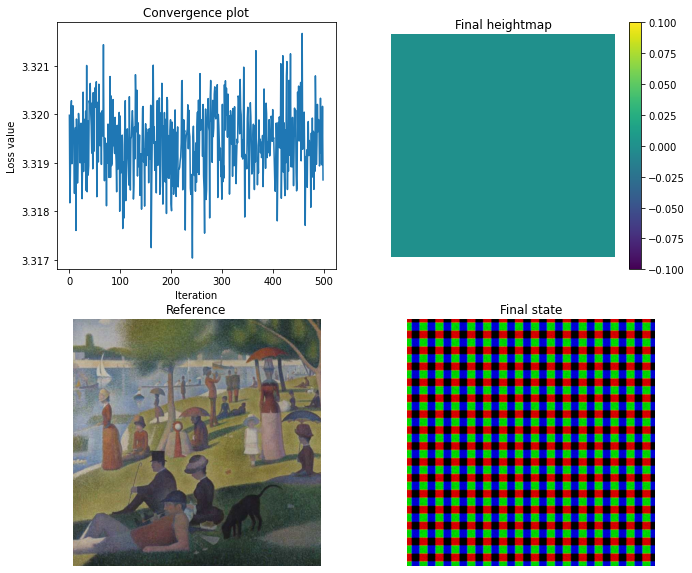

In [19]:
import matplotlib.pyplot as plt
from mitsuba.python.util import convert_to_bitmap

def show_image(ax, img, title):
    ax.imshow(convert_to_bitmap(img, crop_size))
    ax.axis('off')
    ax.set_title(title)
    
def show_heightmap(fig, ax, values, title):
    values = params['data'].numpy().reshape(crop_size)
    im = ax.imshow(values)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(title)
    

fig, ax = plt.subplots(2, 2, figsize=(11, 10))
ax = ax.ravel()
ax[0].plot(loss_values)
ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); ax[0].set_title('Convergence plot')

show_heightmap(fig, ax[1], params['data'], 'Final heightmap')
show_image(ax[2], image_ref, 'Reference')
show_image(ax[3], image, 'Final state')
plt.show()

Congratulations! Feel free to define your own target images at the top of the notebook and run this tutorial again.

If you would like to improve the quality of the results, you could try the following:
- Letting the optimization run for more iterations
- Tweaking the learning rate and sample count
- Progressively increasing the resolution of the heightmap through optimization, e.g. starting from a 16x16 heightmap and doubling the resolution every N iterations.